In [64]:
import pandas as pd
import main as main
import numpy as np
#import holidays
%load_ext autoreload
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
%matplotlib inline

In [17]:
data = pd.read_csv('BikeSharing_Bluebikes2022.csv', index_col=0)

/home/georgep/anaconda3/envs/MachineLearning/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [18]:
data.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,postal code
0,597,2022-01-01 00:00:25.1660,2022-01-01 00:10:22.1920,178,MIT Pacific St at Purrington St,42.359573,-71.101295,74,Harvard Square at Mass Ave/ Dunster,42.373268,-71.118579,4923,Subscriber,02139
1,411,2022-01-01 00:00:40.4300,2022-01-01 00:07:32.1980,189,Kendall T,42.362428,-71.084955,178,MIT Pacific St at Purrington St,42.359573,-71.101295,3112,Subscriber,02139
2,476,2022-01-01 00:00:54.8180,2022-01-01 00:08:51.6680,94,Main St at Austin St,42.375603,-71.064608,356,Charlestown Navy Yard,42.374125,-71.054812,6901,Customer,02124
3,466,2022-01-01 00:01:01.6080,2022-01-01 00:08:48.2350,94,Main St at Austin St,42.375603,-71.064608,356,Charlestown Navy Yard,42.374125,-71.054812,5214,Customer,02124
4,752,2022-01-01 00:01:06.0520,2022-01-01 00:13:38.2300,19,Park Dr at Buswell St,42.347241,-71.105301,41,Packard's Corner - Commonwealth Ave at Brighto...,42.352261,-71.123831,2214,Subscriber,02215


In [19]:
#transforming the dates from object to datetime
for date_column in ['starttime','stoptime']:
    data[date_column] = pd.to_datetime(data[date_column], format='%Y-%m-%d %H:%M:%S')

## Prediction challenge 

In [65]:
%reload_ext autoreload

In [50]:
df15 = main.DatetimeInterval(data, freq='15Min')
df30 = main.DatetimeInterval(data, freq='30Min')
df60 = main.DatetimeInterval(data, freq='60Min')
df120 = main.DatetimeInterval(data, freq='120Min')
picks15 = main.Lagging(df15, 15)
picks30 = main.Lagging(df30, 30).dropna()
picks60 = main.Lagging(df60, 60).dropna()
picks120 = main.Lagging(df120, 120).dropna()

In [66]:
def ModelRunningResults(models,models_name, first_row, picks):
    results = {}
    table = [first_row]
    pipe = main.PredictionPipeline(picks)
    X_train, X_test, y_train, y_test = pipe.PredictionDataPreperation()
    for model, model_name in zip(models,models_name):
        CV_score, CV_MSE, test_score, test_MSE = pipe.BackTestingPrediction(model, model_name, X_train, X_test, y_train, y_test)
        results[model_name] = {'Cross Validation Score': CV_score, 'Cross Validation MSE': CV_MSE, 'Test Score':test_score, 'Test MSE':test_MSE}
        row = [model_name, np.max(CV_score), np.min(CV_MSE), test_score, test_MSE]
        table.append(row)      

    return table

In [67]:
models = [LinearRegression(),Ridge(),Lasso(),RandomForestRegressor(),ExtraTreesRegressor()]
models_name = ['LinearRegression','RidgeRegression','LassoRegression','RandomForestRegressor','ExtraTreesRegressor']
first_row = ['Model','OptimalCrossValScore','OptimalCrossValMSE','OptimalTestScore','OptimalTestMSE']
print('The Prediction based on {} minutes intervals \n'.format(15))
table = ModelRunningResults(models,models_name, first_row, picks15)
print(tabulate(table, headers='firstrow',colalign=("left",), floatfmt=".4f"))

The Prediction based on 15 minutes intervals 


 LinearRegression

CV Train Score:  0.7753762328425267
CV Train RMSE :  12.67689057213289
CV Score:     0.7542069063116529
CV MSE :     20.098985383511422

CV Train Score:  0.7768742586630271
CV Train RMSE :  16.38427627524303
CV Score:     0.7106767156548907
CV MSE :     30.097351633437256

CV Train Score:  0.7645684172004834
CV Train RMSE :  21.89949932843529
CV Score:     0.7471001883070908
CV MSE :     39.44839054120753

CV Train Score:  0.7944529720596626
CV Train RMSE :  27.09474790064098
CV Score:     0.7481033924247611
CV MSE :     46.00667160719352

CV Train Score:  0.8050286195701398
CV Train RMSE :  31.78321439974883
CV Score:     0.7137667070047515
CV MSE :     57.667476924251005

CV Train Score:  0.7976502226211877
CV Train RMSE :  37.23027735687573
CV Score:     0.7319608186766087
CV MSE :     55.510414345427975

Train Score:  0.7977904657370996
Train RMSE :  40.35531189050665
Test Score:  0.7474512057237725
Test MSE :    64

In [68]:
models = [LinearRegression(),Ridge(),Lasso(),RandomForestRegressor(),ExtraTreesRegressor()]
models_name = ['LinearRegression','RidgeRegression','LassoRegression','RandomForestRegressor','ExtraTreesRegressor']
first_row = ['Model','OptimalCrossValScore','OptimalCrossValMSE','OptimalTestScore','OptimalTestMSE']
print('The Prediction based on {} minutes intervals \n'.format(30))
table = ModelRunningResults(models,models_name, first_row, picks30)
print(tabulate(table,headers='firstrow',colalign=("left",), floatfmt=".4f"))

The Prediction based on 30 minutes intervals 


 LinearRegression

CV Train Score:  0.7649463311082461
CV Train RMSE :  25.648178958494547
CV Score:     0.7344728766700241
CV MSE :     41.39174759868678

CV Train Score:  0.7627770385201709
CV Train RMSE :  33.4669371801797
CV Score:     0.6777229232225935
CV MSE :     63.06106439540864

CV Train Score:  0.7431852394099271
CV Train RMSE :  45.397745439203234
CV Score:     0.7141600085576192
CV MSE :     83.31666481495797

CV Train Score:  0.7727460157148357
CV Train RMSE :  56.63009286317528
CV Score:     0.7181230629441877
CV MSE :     96.68644952314791

CV Train Score:  0.7840570214946705
CV Train RMSE :  66.52502756767012
CV Score:     0.675044510820424
CV MSE :     122.12297490522465

CV Train Score:  0.7740875677296774
CV Train RMSE :  78.26205238576209
CV Score:     0.6946909008274949
CV MSE :     117.75771316166299

Train Score:  0.7732868460145569
Train RMSE :  85.02424247788859
Test Score:  0.7129080472660533
Test MSE :    136.

In [69]:
models = [LinearRegression(),Ridge(),Lasso(),RandomForestRegressor(),ExtraTreesRegressor()]
models_name = ['LinearRegression','RidgeRegression','LassoRegression','RandomForestRegressor','ExtraTreesRegressor']
first_row = ['Model','OptimalCrossValScore','OptimalCrossValMSE','OptimalTestScore','OptimalTestMSE']
print('The Prediction based on {} minutes intervals \n'.format(60))
table = ModelRunningResults(models,models_name, first_row, picks60)
print(tabulate(table,headers='firstrow',colalign=("left",), floatfmt=".4f"))

The Prediction based on 60 minutes intervals 


 LinearRegression

CV Train Score:  0.7325664716787956
CV Train RMSE :  54.1255230794317
CV Score:     0.6829401598304388
CV MSE :     89.45631639902517

CV Train Score:  0.7236136682004484
CV Train RMSE :  71.4848476570639
CV Score:     0.5954420043949438
CV MSE :     139.8016502942177

CV Train Score:  0.6877677020815383
CV Train RMSE :  99.14063004198208
CV Score:     0.6258954462300343
CV MSE :     188.70689753300843

CV Train Score:  0.71629491968301
CV Train RMSE :  125.473940240534
CV Score:     0.6363373146006083
CV MSE :     217.47153702648848

CV Train Score:  0.7288484331810179
CV Train RMSE :  147.90972166630564
CV Score:     0.5850254892359306
CV MSE :     273.0271220160186

CV Train Score:  0.7162009514268604
CV Train RMSE :  174.02697985874588
CV Score:     0.5999554279860486
CV MSE :     266.92607156667697

Train Score:  0.7126952620059607
Train RMSE :  189.91913822226226
Test Score:  0.6156646773445562
Test MSE :    311.7

In [70]:
models = [LinearRegression(),Ridge(),Lasso(),RandomForestRegressor(),ExtraTreesRegressor()]
models_name = ['LinearRegression','RidgeRegression','LassoRegression','RandomForestRegressor','ExtraTreesRegressor']
first_row = ['Model','OptimalCrossValScore','OptimalCrossValMSE','OptimalTestScore','OptimalTestMSE']
print('The Prediction based on {} minutes intervals \n'.format(120))
table = ModelRunningResults(models,models_name, first_row, picks120)
print(tabulate(table,headers='firstrow',colalign=("left",), floatfmt=".4f"))

The Prediction based on 120 minutes intervals 


 LinearRegression

CV Train Score:  0.7902167798097253
CV Train RMSE :  93.4551380285334
CV Score:     0.7515679713334942
CV MSE :     153.81233080349233

CV Train Score:  0.7855821881304966
CV Train RMSE :  122.58840107111025
CV Score:     0.6736310482569444
CV MSE :     242.92643461775563

CV Train Score:  0.7536216785813107
CV Train RMSE :  171.29894499000304
CV Score:     0.6913823856457634
CV MSE :     333.4444830062863

CV Train Score:  0.7737585453556411
CV Train RMSE :  218.86837686243038
CV Score:     0.7106277538740229
CV MSE :     376.1156223920249

CV Train Score:  0.7863580373359274
CV Train RMSE :  256.585413759418
CV Score:     0.6725781522261662
CV MSE :     466.0410325962561

CV Train Score:  0.7787855235323475
CV Train RMSE :  299.52226053269294
CV Score:     0.6860706548454854
CV MSE :     454.6984802690551

Train Score:  0.7772256922746543
Train RMSE :  325.67663429588026
Test Score:  0.6942427294090064
Test MSE :    

## MODELLING

In [115]:
picksup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11659 entries, 4 to 11662
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   temp                 11659 non-null  float64
 1   feelslike            11659 non-null  float64
 2   humidity             11659 non-null  float64
 3   precip               11659 non-null  float64
 4   snow                 11659 non-null  float64
 5   snowdepth            11659 non-null  float64
 6   windspeed            11659 non-null  float64
 7   visibility           11659 non-null  float64
 8   uvindex              11659 non-null  float64
 9   severerisk           11659 non-null  float64
 10  enc_preciptype       11659 non-null  float64
 11  enc_conditions       11659 non-null  float64
 12  usertype_Customer    11659 non-null  float64
 13  usertype_Subscriber  11659 non-null  float64
 14  pickups              11659 non-null  float64
 15  workingday           11659 non-null 

In [116]:
picksup.head()

,temp,feelslike,humidity,precip,snow,snowdepth,windspeed,visibility,uvindex,severerisk,...,workingday,holiday,month,hour,minute,season_Spring,season_Summer,season_Winter,"lag(pickups,60-90)","lag(pickups,90-120)"
4,7.2,6.5,96.49,0.0,0.0,0.0,5.3,5.1,0.0,10.0,...,0,1,1,2,0,0,0,1,59.0,66.0
5,7.2,6.5,96.49,0.0,0.0,0.0,5.3,5.1,0.0,10.0,...,0,1,1,2,30,0,0,1,43.0,59.0
6,7.2,6.0,96.49,0.0,0.0,0.0,7.3,4.0,0.0,10.0,...,0,1,1,3,0,0,0,1,49.0,43.0
7,7.2,6.0,96.49,0.0,0.0,0.0,7.3,4.0,0.0,10.0,...,0,1,1,3,30,0,0,1,41.0,49.0
8,7.2,7.2,96.60,0.0,0.0,0.0,0.1,1.0,0.0,10.0,...,0,1,1,4,0,0,0,1,32.0,41.0


In [117]:
X = picksup.drop(['pickups','usertype_Subscriber','usertype_Customer','enc_preciptype','enc_conditions','precip','snow', 'feelslike', 'uvindex', 'severerisk'], axis=1)
y = picksup[['month','hour','pickups']]

In [118]:
X.head()

,temp,humidity,snowdepth,windspeed,visibility,workingday,holiday,month,hour,minute,season_Spring,season_Summer,season_Winter,"lag(pickups,60-90)","lag(pickups,90-120)"
4,7.2,96.49,0.0,5.3,5.1,0,1,1,2,0,0,0,1,59.0,66.0
5,7.2,96.49,0.0,5.3,5.1,0,1,1,2,30,0,0,1,43.0,59.0
6,7.2,96.49,0.0,7.3,4.0,0,1,1,3,0,0,0,1,49.0,43.0
7,7.2,96.49,0.0,7.3,4.0,0,1,1,3,30,0,0,1,41.0,49.0
8,7.2,96.60,0.0,0.1,1.0,0,1,1,4,0,0,0,1,32.0,41.0


In [119]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
scaling_columns = ['temp', 'windspeed', 'humidity', 'snowdepth', 'visibility']
lag_columns = [c for c in X.columns if c.startswith("lag")]
X[scaling_columns+lag_columns] = sc_X.fit_transform(X[scaling_columns + lag_columns])

In [120]:
X.head()

,temp,humidity,snowdepth,windspeed,visibility,workingday,holiday,month,hour,minute,season_Spring,season_Summer,season_Winter,"lag(pickups,60-90)","lag(pickups,90-120)"
4,-0.465538,1.680543,-0.375249,-1.433655,-2.756937,0,1,1,2,0,0,0,1,-0.707038,-0.671528
5,-0.465538,1.680543,-0.375249,-1.433655,-2.756937,0,1,1,2,30,0,0,1,-0.788751,-0.707317
6,-0.465538,1.680543,-0.375249,-1.204263,-3.067343,0,1,1,3,0,0,0,1,-0.758109,-0.789119
7,-0.465538,1.680543,-0.375249,-1.204263,-3.067343,0,1,1,3,30,0,0,1,-0.798966,-0.758443
8,-0.465538,1.685982,-0.375249,-2.030076,-3.913905,0,1,1,4,0,0,0,1,-0.844929,-0.799344


In [121]:
X[['workingday', 'holiday', 'month', 'hour', 'minute',
'season_Spring', 'season_Summer', 'season_Winter']] = X[['workingday', 'holiday', 'month', 'hour', 'minute',
                                                               'season_Spring', 'season_Summer', 'season_Winter']].astype('category')

In [122]:
X.head()

,temp,humidity,snowdepth,windspeed,visibility,workingday,holiday,month,hour,minute,season_Spring,season_Summer,season_Winter,"lag(pickups,60-90)","lag(pickups,90-120)"
4,-0.465538,1.680543,-0.375249,-1.433655,-2.756937,0,1,1,2,0,0,0,1,-0.707038,-0.671528
5,-0.465538,1.680543,-0.375249,-1.433655,-2.756937,0,1,1,2,30,0,0,1,-0.788751,-0.707317
6,-0.465538,1.680543,-0.375249,-1.204263,-3.067343,0,1,1,3,0,0,0,1,-0.758109,-0.789119
7,-0.465538,1.680543,-0.375249,-1.204263,-3.067343,0,1,1,3,30,0,0,1,-0.798966,-0.758443
8,-0.465538,1.685982,-0.375249,-2.030076,-3.913905,0,1,1,4,0,0,0,1,-0.844929,-0.799344


In [134]:
X_train = X[X['month']!=8]
X_test = X[X['month']==8]
y_train = y[y['month']!=8]
y_test = y[y['month']==8]

In [135]:
X_train

,temp,humidity,snowdepth,windspeed,visibility,workingday,holiday,month,hour,minute,season_Spring,season_Summer,season_Winter,"lag(pickups,60-90)","lag(pickups,90-120)"
4,-0.465538,1.680543,-0.375249,-1.433655,-2.756937,0,1,1,2,0,0,0,1,-0.707038,-0.671528
5,-0.465538,1.680543,-0.375249,-1.433655,-2.756937,0,1,1,2,30,0,0,1,-0.788751,-0.707317
6,-0.465538,1.680543,-0.375249,-1.204263,-3.067343,0,1,1,3,0,0,0,1,-0.758109,-0.789119
7,-0.465538,1.680543,-0.375249,-1.204263,-3.067343,0,1,1,3,30,0,0,1,-0.798966,-0.758443
8,-0.465538,1.685982,-0.375249,-2.030076,-3.913905,0,1,1,4,0,0,0,1,-0.844929,-0.799344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10171,1.397459,-1.257989,-0.375249,-0.171996,0.318904,0,0,7,21,30,0,1,0,1.861818,1.532026
10172,1.334153,-1.034002,-0.375249,-0.584903,0.318904,0,0,7,22,0,0,1,0,2.060994,1.864349
10173,1.334153,-1.034002,-0.375249,-0.584903,0.318904,0,0,7,22,30,0,1,0,1.943532,2.063742
10174,1.080930,-0.423353,-0.375249,-0.412858,0.318904,0,0,7,23,0,0,1,0,1.524752,1.946151


In [136]:
X.columns

Index(['temp', 'humidity', 'snowdepth', 'windspeed', 'visibility',
       'workingday', 'holiday', 'month', 'hour', 'minute', 'season_Spring',
       'season_Summer', 'season_Winter', 'lag(pickups,60-90)',
       'lag(pickups,90-120)'],
      dtype='object')

In [137]:
def FeaturesSelection(df):
    features_list = [
        'temp', 
        'humidity',
        'snowdepth',
        'windspeed',
        'visibility',
        'workingday',
        'holiday',
        'month',
        'hour',
         #'minute',
        'season_Spring',
        'season_Summer',
        'season_Winter',
        #'lag(pickups,60-75)',
        #'lag(pickups,75-90)',
        #'lag(pickups,90-105)',
        #'lag(pickups,105-120)'
        #'lag(pickups,60-90)',
        #'lag(pickups,90-120)'
        #'lag(pickups,60-120)',
       'lag(pickups,60-90)',
       'lag(pickups,90-120)'
    ]
    return df[features_list]

In [138]:
y_train

,month,hour,pickups
4,1,2,41.0
5,1,2,32.0
6,1,3,42.0
7,1,3,53.0
8,1,4,40.0
...,...,...,...
10171,7,21,496.0
10172,7,22,585.0
10173,7,22,521.0
10174,7,23,458.0


In [139]:
X_train.month.unique()

[1, 2, 3, 4, 5, 6, 7]
Categories (7, int64): [1, 2, 3, 4, 5, 6, 7]

In [154]:
# Back Testing
X_train = FeaturesSelection(X_train)
X_test = FeaturesSelection(X_test)

CV = []

LRM = Lasso()
for m in  X_train.month.unique()[:-1]:
    CV.append(m)
    xtemp_train = X_train[X_train['month'].isin(CV)]
    ytemp_train = y_train[y_train['month'].isin(CV)]['pickups']
    xtemp_test = X_train[X_train['month']==m+1]
    ytemp_test = y_train[y_train['month']==m+1]['pickups']
    
    LRM.fit(xtemp_train, ytemp_train)
    train_temp_preds = LRM.predict(xtemp_train)
    test_temp_preds = LRM.predict(xtemp_test)
    
    print('\nTrain Score: ',  LRM.score(xtemp_train, ytemp_train))
    print('Train RMSE : ',  np.sqrt(mean_squared_error(ytemp_train, train_temp_preds)))
    print('CV Score:    ',  LRM.score(xtemp_test, ytemp_test))
    print('CV MSE :    ',  np.sqrt(mean_squared_error(ytemp_test, test_temp_preds)))

LRM.fit(X_train, y_train['pickups'])          
print('\nFINAL')
print('Test Score: ', LRM.score(X_test, y_test['pickups']))
print('CV MSE :   ', np.sqrt(mean_squared_error(y_test['pickups'], LRM.predict(X_test))))


Train Score:  0.7784392130445563
Train RMSE :  24.901153624068463
CV Score:     0.7238958711176362
CV MSE :     42.2080966638027

Train Score:  0.7810808813287593
Train RMSE :  32.149887117165264
CV Score:     0.6873023456948419
CV MSE :     62.116775128775835

Train Score:  0.7556132195011378
Train RMSE :  44.28566287107488
CV Score:     0.7065288703574408
CV MSE :     84.42150176471158

Train Score:  0.7779034140160647
Train RMSE :  55.983811401075904
CV Score:     0.7073438121941
CV MSE :     98.51779800477483

Train Score:  0.7907420216640393
Train RMSE :  65.48721662012811
CV Score:     0.6791022551896555
CV MSE :     121.3581001170452

Train Score:  0.783204227518004
Train RMSE :  76.66666498784073
CV Score:     0.6905580416456145
CV MSE :     118.55205586514279

FINAL
Test Score:  0.7035471820197143
CV MSE :    138.30346126093247


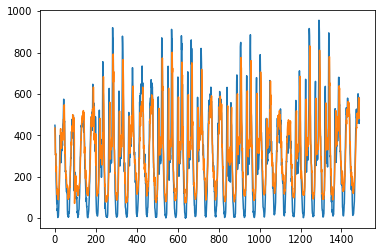

In [155]:
plt.plot(ytemp_test.values)
plt.plot(test_temp_preds)

In [156]:
ytemp_test

8688     449.0
8689     437.0
8690     398.0
8691     305.0
8692     311.0
         ...  
10171    496.0
10172    585.0
10173    521.0
10174    458.0
10175    472.0
Name: pickups, Length: 1488, dtype: float64

In [157]:
test_temp_preds

array([435.72363907, 391.92380696, 319.76571882, ..., 553.88465399,
       482.79065363, 575.06842478])